## 2. Encoder-Decoder sobre imágenes
---
En la presente seccion se experimentará con arquitecturas del tipo *encoder-decoder* [[3]](#refs) aplicadas sobre imágenes, tales como *image translation*, *object location*, *image segmentation*, entre otros. La idea es aplicar una red convolucional en ambas partes del modelo (encoder y decoder), así utilizamos un modelo que se adapte a estos casos.

La tarea consistirá en realizar **Image Segmentation** [[4]](#refs) para identificar ciertos segmentos o regiones de interés en una imagen a través de procesar de manera semántica (en la codificación) si cada pixel corresponde a un segmento a destacar. Esta tarea puede ser aplicada tanto para identificar un segmento como para identificar múltiples segmentos a través de colocar varios canales/filtros de salida en el *decoder*. Para ésto trabajaremos con un dataset creado en el área (*A BENCHMARK FOR SEMANTIC IMAGE SEGMENTATION*). El dataset resulta bastante pequeño en cantidad de datos, por lo que deberá pensar en formas de conllevar ésto.

> a) Explore los datos a trabajar, visualice la entrada y salida del modelo, además de las dimensionalidades de éstas ¿Es un problema las dimensiones de los datos *versus* la cantidad de datos a entrenar? Normalice los datos como se acostumbra en imágenes y genere una dimensión/canal extra a la salida.

In [1]:
import numpy as np
import os as os
import matplotlib.pyplot as plt

from PIL import Image as image


img_size = 100
data_dir = 'data/2'
filenames = [data_file.split('.')[0] for data_file in os.listdir(f'{data_dir}/image')]

X = np.asarray([
    np.asarray(
        image.open(f'{data_dir}/image/{filename}.jpg')
            .resize((img_size, img_size), image.ANTIALIAS),
        dtype=np.uint8
    )
    for filename in filenames
])

Y = np.asarray([
    np.asarray(
        image.open(f'{data_dir}/ground-truth/{filename}.png')
            .resize((img_size, img_size), image.ANTIALIAS),
        dtype=np.uint8
    )
    for filename in filenames
])

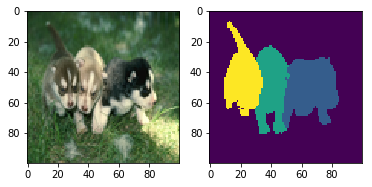

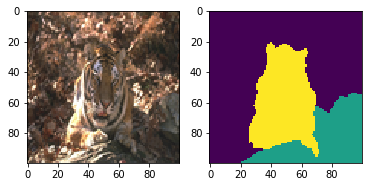

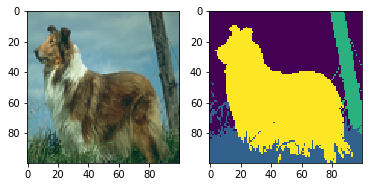

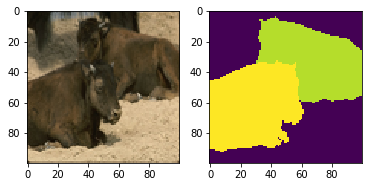

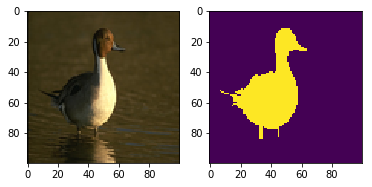

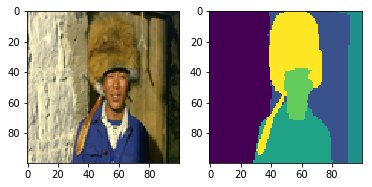

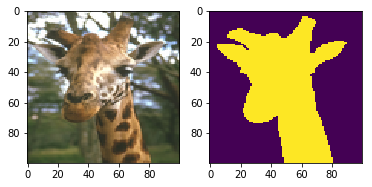

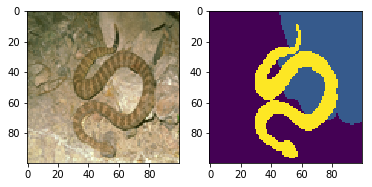

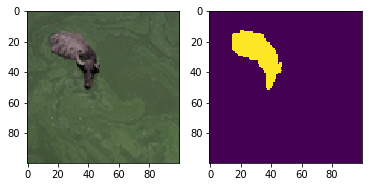

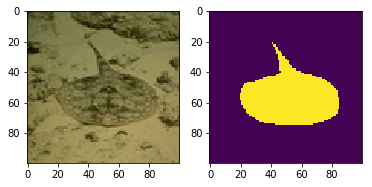

In [2]:
for i in range(10):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(X[i])
    ax[1].imshow(Y[i])

- Hablar de que las imgs son heterogeneas
- Hablar de que se escalaron a 80x80 (no es bueno tener muchas dimensiones, son pocos ejemplos)
- Hablar de que en general se separa sujeto del fondo, tal vez el color morado es irrelevante y podria ser negro, asi la red solo debe predecir cuales pixeles se deben encender

> b) Separe 10 imágenes como conjunto de pruebas para verificar la calidad del modelo entrenado.

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

X, Y = X / 255., Y / 255.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=10, random_state=42)

Using TensorFlow backend.


> c) Debido a la poca cantidad de datos presentes defina la arquitectura a utilizando únicamente convolucionales (*fully convolutional*) [[5]](#refs), como la presente en el código. Comente sobre los cambios en la dimensionalidad a través del *forward pass*. Decida el tamaño del *batch* en base a la cantidad de datos que se presenta para entrenar.

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, UpSampling2D, BatchNormalization

model = Sequential()
#ENCODER PART
model.add(Conv2D(32, (3, 3), activation='relu', padding='same',input_shape=X.shape[1:]))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#DECODER PART
model.add(UpSampling2D((2, 2)))
model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2DTranspose(1, (3, 3), strides=(2,2), activation='sigmoid', padding='same')) #pixel-wise classification
model.summary()
model.compile(loss='binary_crossentropy',optimizer='rmsprop')
h = model.fit(X_train, Y_train[:,:,:,None], epochs=100, batch_size=10, validation_data=(X_test, Y_test[:,:,:,None]))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv

90/90 [==============================] - 3s 36ms/step - loss: 0.5333 - val_loss: 0.5135
Epoch 58/100
90/90 [==============================] - 3s 36ms/step - loss: 0.4748 - val_loss: 0.5428
Epoch 59/100
90/90 [==============================] - 3s 36ms/step - loss: 0.4765 - val_loss: 0.5013
Epoch 60/100
90/90 [==============================] - 3s 36ms/step - loss: 0.4686 - val_loss: 0.5690
Epoch 61/100
90/90 [==============================] - 3s 36ms/step - loss: 0.4804 - val_loss: 0.5170
Epoch 62/100
90/90 [==============================] - 3s 36ms/step - loss: 0.4843 - val_loss: 0.5337
Epoch 63/100
90/90 [==============================] - 3s 36ms/step - loss: 0.4682 - val_loss: 0.5282
Epoch 64/100
90/90 [==============================] - 3s 36ms/step - loss: 0.4592 - val_loss: 0.5164
Epoch 65/100
90/90 [==============================] - 3s 36ms/step - loss: 0.4804 - val_loss: 0.5165
Epoch 66/100
90/90 [==============================] - 3s 36ms/step - loss: 0.4929 - val_loss: 0.5079
Epo

- Comentar sobre el tamano del batch que en general queremos que no sea tan grande. Es bueno aumentar el tamano para permitir que la red generalice, pero las imagenes son tan distintas entre si, que mezclar muchas puede porducir mucho ruido.

> d) Para medir el desempeño del modelo sobre ambos conjuntos realice un análisis cualitativo en base a visualizar la segmentación que realiza *versus* la segmentación real, además de verificar el *precision* y *recall* asumiendo valores binarios de pixel ¿Qué valor debería ser más importante los ceros o 1? Comente.

In [5]:
from sklearn.metrics import precision_score, recall_score

Y_train_label = Y_train.flatten() > 0.5
Y_test_label  = Y_test.flatten()  > 0.5

Y_hat_train_label = np.squeeze(model.predict(X_train)).flatten() > 0.5
Y_hat_test_label  = np.squeeze(model.predict(X_test)).flatten()  > 0.5

precision_train = precision_score(Y_train_label, Y_hat_train_label, average=None, labels=(0,1))
precision_test  = precision_score(Y_test_label, Y_hat_test_label, average=None, labels=(0,1))

recall_train = recall_score(Y_train_label, Y_hat_train_label, average=None, labels=(0,1))
recall_test  = recall_score(Y_test_label, Y_hat_test_label, average=None, labels=(0,1))

print('[TRAIN] Precision\t%s' % precision_train)
print('[TRAIN] Recall\t\t%s' % recall_train)

print('[TEST] Precision\t%s' % precision_test)
print('[TEST] Recall\t\t%s' % recall_test)

[TRAIN] Precision	[0.85766083 0.7313576 ]
[TRAIN] Recall		[0.87700368 0.69702282]
[TEST] Precision	[0.8216138  0.56976359]
[TEST] Recall		[0.81527132 0.58019488]


- Comentar que el precision y recall es bueno para 0, esto es porque hay una tendencia a tener imgs con mas fondo que sujeto.
- Por lo tanto el accuracy y recall de los 1 son mas importantes, nos indica que tan buena es la red discriminando al sujeto del fondo.
- Indicar que a continuacion estan las predicciones generadas por la maquina, que no es perfecta, pero logra generar siluetas que separan al sujeto del fondo con una calidad suficiente para que un ser humano las interprete.

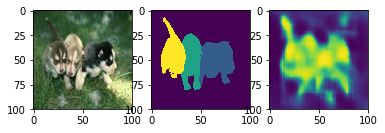

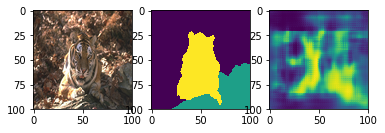

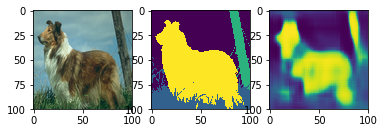

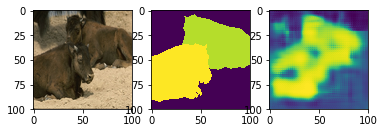

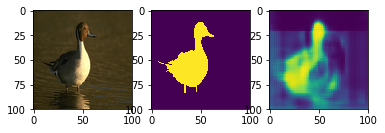

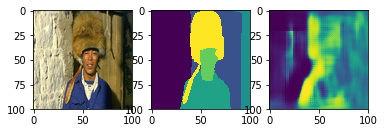

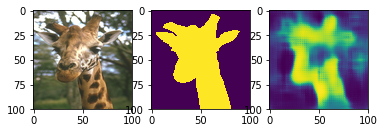

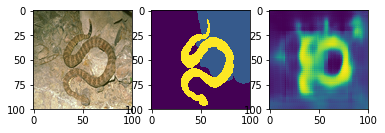

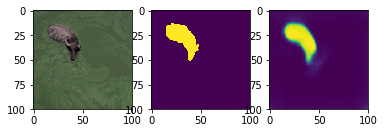

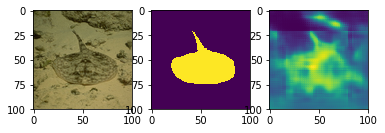

In [6]:
for i in range(10):
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(X[i])
    ax[1].imshow(Y[i])
    ax[2].imshow(np.squeeze(model.predict(X[:i+1])[-1], axis=2))

> e) Compárese con alguna técnica manual de *Image Segmentation*, comúnmente se sugiere considerar un *treshold* para activar o apagar un píxel. Experimente con utilizar *treshold* igual a la media o con otra técnica más inteligente basada en los histogramas de escala de grises, como se utilizan en *skimage*.

In [7]:
from skimage import filters

X_gray = 0.333333 * X[:,:,:,0] + 0.333333 * X[:,:,:,1] + 0.333333 * X[:,:,:,2]
threshold_X = filters.threshold_otsu(X_gray)
mask_X = X_gray < threshold_X
X_segmented = mask_X * 1

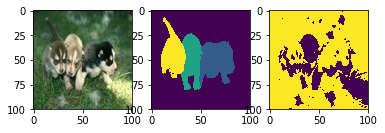

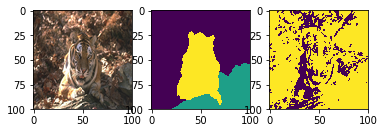

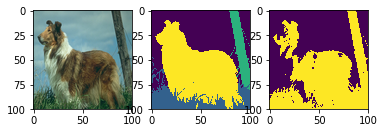

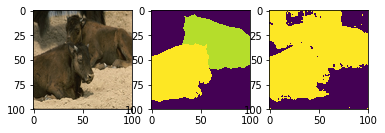

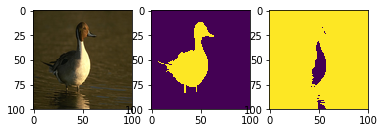

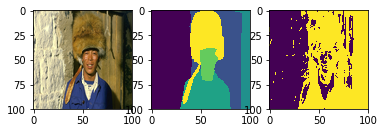

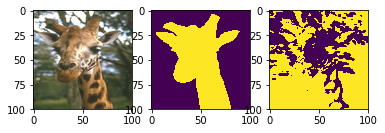

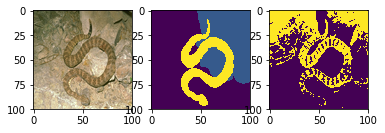

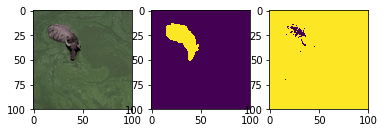

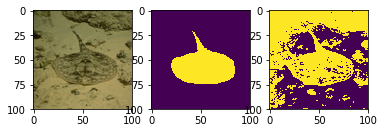

In [8]:
for i in range(10):
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(X[i])
    ax[1].imshow(Y[i])
    ax[2].imshow(X_segmented[i])

In [9]:
X_segmented = np.expand_dims(X_segmented, axis=3)
X_train_seg, X_test_seg, Y_train_seg, Y_test_seg = train_test_split(X_segmented, Y, test_size=10, random_state=42)

In [10]:
model = Sequential()
#ENCODER PART
model.add(Conv2D(32, (3, 3), activation='relu', padding='same',input_shape=X_train_seg[0].shape))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#DECODER PART
model.add(UpSampling2D((2, 2)))
model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2DTranspose(1, (3, 3), strides=(2,2), activation='sigmoid', padding='same')) #pixel-wise classification
model.summary()
model.compile(loss='binary_crossentropy',optimizer='rmsprop')
h = model.fit(X_train_seg, Y_train_seg[:,:,:,None], epochs=100, batch_size=10, validation_data=(X_test_seg, Y_test_seg[:,:,:,None]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 25, 25, 128)       73856     
__________

Epoch 63/100
90/90 [==============================] - 3s 35ms/step - loss: 0.4999 - val_loss: 0.5804
Epoch 64/100
90/90 [==============================] - 3s 35ms/step - loss: 0.5087 - val_loss: 0.5976
Epoch 65/100
90/90 [==============================] - 3s 35ms/step - loss: 0.5076 - val_loss: 0.5684
Epoch 66/100
90/90 [==============================] - 3s 35ms/step - loss: 0.4881 - val_loss: 0.6068
Epoch 67/100
90/90 [==============================] - 3s 35ms/step - loss: 0.5025 - val_loss: 0.5970
Epoch 68/100
90/90 [==============================] - 3s 35ms/step - loss: 0.4900 - val_loss: 0.6009
Epoch 69/100
90/90 [==============================] - 3s 35ms/step - loss: 0.4858 - val_loss: 0.5800
Epoch 70/100
90/90 [==============================] - 3s 35ms/step - loss: 0.4832 - val_loss: 0.5813
Epoch 71/100
90/90 [==============================] - 3s 35ms/step - loss: 0.4944 - val_loss: 0.6143
Epoch 72/100
90/90 [==============================] - 3s 35ms/step - loss: 0.5012 - val_los

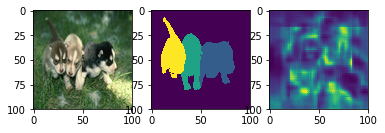

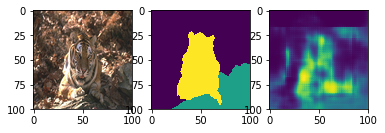

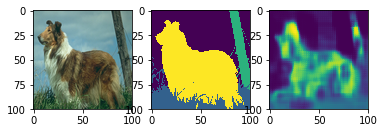

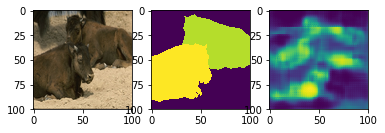

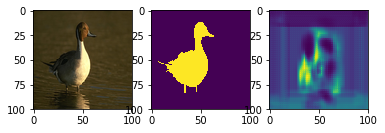

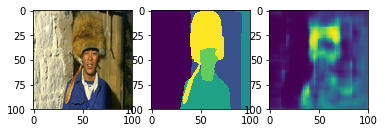

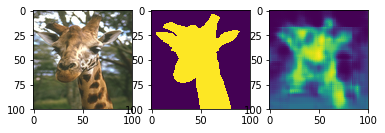

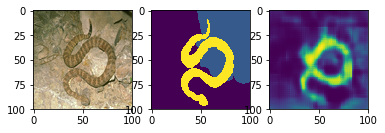

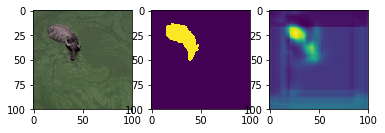

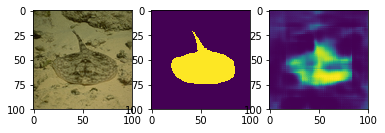

In [11]:
for i in range(10):
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(X[i])
    ax[1].imshow(Y[i])
    ax[2].imshow(np.squeeze(model.predict(X_segmented[:i+1])[-1], axis=2))

In [12]:
Y_seg_train_label = Y_train_seg.flatten() > 0.5
Y_seg_test_label  = Y_test_seg.flatten()  > 0.5

Y_seg_hat_train_label = np.squeeze(model.predict(X_train_seg)).flatten() > 0.5
Y_seg_hat_test_label  = np.squeeze(model.predict(X_test_seg)).flatten()  > 0.5

precision_train = precision_score(Y_seg_train_label, Y_seg_hat_train_label, average=None, labels=(0,1))
precision_test  = precision_score(Y_seg_test_label, Y_seg_hat_test_label, average=None, labels=(0,1))

recall_train = recall_score(Y_seg_train_label, Y_seg_hat_train_label, average=None, labels=(0,1))
recall_test  = recall_score(Y_seg_test_label, Y_seg_hat_test_label, average=None, labels=(0,1))

print('[TRAIN] Precision\t%s' % precision_train)
print('[TRAIN] Recall\t\t%s' % recall_train)

print('[TEST] Precision\t%s' % precision_test)
print('[TEST] Recall\t\t%s' % recall_test)

[TRAIN] Precision	[0.76695136 0.94186437]
[TRAIN] Recall		[0.98889538 0.37449795]
[TEST] Precision	[0.71032662 0.40420599]
[TEST] Recall		[0.94884918 0.08230217]


In [13]:
generator = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=270,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)
generator.fit(X_train)